In [1]:
from keras.datasets import boston_housing
import numpy as np
import pandas as pd

''', у нас имеются 404 обучающих и 102 контрольных образца, каждый 
с 13 числовыми признаками, такими как уровень преступности, среднее число 
комнат в доме, удаленность от центральных дорог и т. д.
Цели — медианные значения цен на дома, занимаемые собственниками, в тысячах 
долларов:'''

#==============================ВХОДНЫЕ ДАННЫЕ==============================#

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()


#==============================ПРЕОБРАЗОВАНИЕ ВХОДНЫХ ДАННЫХ==============================#

#Нормализация обучающих данных и тестовых (потому что проблематично работать с данными разных диапазонов)
'''Величины, используемые для нормализации контрольных данных, вычисляются с использованием обучающих данных. 
Никогда не следует использовать в работе какие-либо значения, вычисленные по контрольным 
данным, даже для таких простых шагов, как нормализация данных.'''

mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data -= mean
train_data /= std
test_data -= mean
test_data /= std


#==============================СОЗДАНИЕ СЕТИ (СЛОИ И КОМПИЛЯЦИЯ)==============================#

'''Из-за небольшого количества образцов мы будем использовать очень маленькую 
сеть с двумя четырехмерными промежуточными слоями. Вообще говоря, чем 
меньше обучающих данных, тем скорее наступит переобучение, а использование 
маленькой сети — один из способов борьбы с ним.'''

from keras import models
from keras import layers
def build_model():
    model = models.Sequential() 
    model.add(layers.Dense(64, activation='relu',input_shape=(None,train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

print(train_data.shape[1])
'''Сеть заканчивается одномерным слоем, не имеющим функции активации (это 
линейный слой). Это типичная конфигурация для скалярной регрессии 
(целью которой является предсказание одного значения на непрерывной числовой прямой)'''

'''mae — mean 
absolute error (средняя абсолютная ошибка). Это абсолютное значение разности 
между предсказанными и целевыми значениями. Например, значение MAE, равное 0,5, 
в этой задаче означает, что в среднем прогнозы отклоняются на 500 долларов США.'''


#==============================ПЕРЕКРЁСТНАЯ ПРОВЕРКА ПО К БЛОКАМ==============================#
# мы так делаем, потому что у нас мало входных данных

import numpy as np
k = 4
num_val_samples = len(train_data) // k # Целочисленное деление
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    print(val_data.shape,val_targets.shape)
    
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],train_data[(i + 1) * num_val_samples:]],axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],train_targets[(i + 1) * num_val_samples:]],axis=0)
    
    model = build_model()    
   
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0) # verbose = 0 - Без вывода инфы
 
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0) 
    all_scores.append(val_mae)
    
print(all_scores)
print(np.mean(all_scores))

# В моём случае ошибка равна 2.5, что равно 2500 долларов, 
# что много, потому что диапазон таргетов от 10000 до 50000

13
processing fold # 0
(101, 13) (101,)
processing fold # 1
(101, 13) (101,)
processing fold # 2
(101, 13) (101,)
processing fold # 3
(101, 13) (101,)
[2.006999969482422, 2.9362576007843018, 2.630873680114746, 2.4204201698303223]
2.498637855052948


In [2]:
# Увеличим количество эпох для перекрёстной проверки по K блокам
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] 
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],train_data[(i + 1) * num_val_samples:]],axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],train_targets[(i + 1) * num_val_samples:]],axis=0)
    
    model = build_model() 
    
    history = model.fit(partial_train_data, partial_train_targets,validation_data=(val_data, val_targets),epochs=num_epochs, batch_size=1, verbose=0)
    
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)] # средние мае по всем прогонам

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


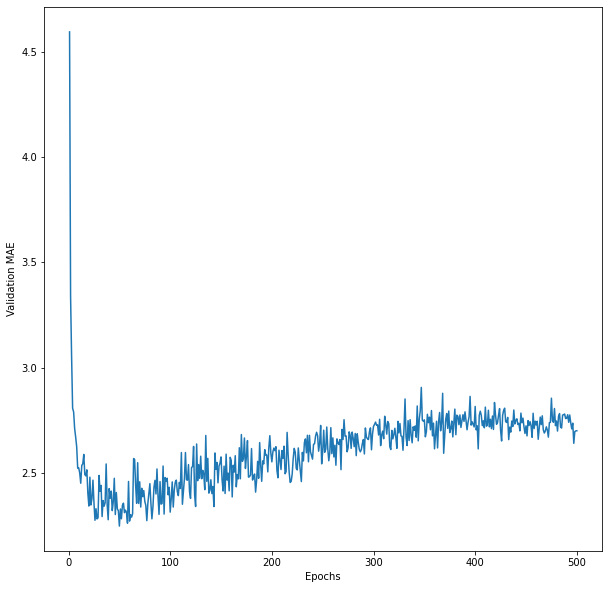

In [4]:
#==============================ВИЗУАЛИЗАЦИЯ MAE==============================#

import matplotlib.pyplot as plt
fig=plt.figure(figsize=(10,10))
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

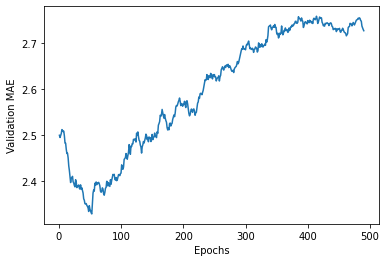

In [5]:
#==============================ВИЗУАЛИЗАЦИЯ сглаженного MAE и в нормальном масштабе ==============================#

def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [6]:
#==============================ОБУЧЕНИЕ ОКОНЧАТЕЛЬНОЙ ВЕРСИИ МОДЕЛИ==============================#

model = build_model() 
model.fit(train_data, train_targets,epochs=80, batch_size=16, verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)


#==============================РЕЗУЛЬТАТЫ==============================#
print(test_mse_score, test_mae_score) # средняя абсолютная ошибка = 2.6 тысячи долларов, что так же много

4/4 [==============================] - 0s 2ms/step - loss: 16.8108 - mae: 2.6314
16.81082534790039 2.631415367126465
